In [145]:
import math
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import ElasticNet,Lasso,Ridge,LinearRegression,ElasticNetCV,LassoCV
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# 1. write the equation that governs the SRE
# M - 2M (1 / (1 + exp((a * x)^b)))

In [146]:
def single_sre(a,b,m,cycles):
        try:
            for cycle in cycles:
                z = 1 + math.exp((a * cycle)**b)
                f = 2* m * ((1/z))
            return f
        except OverflowError:
            z = float('inf')
            return z

In [147]:
from sklearn.metrics import mean_squared_error

In [148]:
def rmse(x,y):
    return np.sqrt(mean_squared_error(x,y))

In [149]:
def r2(actual,predicted):
    df = pd.DataFrame({'actual':actual,'predicted':predicted})
    SS_tot = sum((df['actual']-df['actual'].mean())**2)
    SS_reg = sum((df['actual']-df['predicted'])**2)
    return(1-SS_reg/SS_tot)

In [150]:
def expandgrid(a,b):
    product = list(itertools.product(list(np.ravel(a)),
                                     list(np.ravel(b))))
    df = pd.DataFrame(product,columns=['a','b'])
    return df

# 2. create a range of values for a, b, and m

In [151]:

num_a = 100
num_b = 1
a_range = np.linspace(.02, .03,num_a)
b_range = 0.6
#b_range = seq(.5, .7, length.out = num_b)
m_range = 20.5 # fixed

In [152]:
all_combinations = expandgrid(a_range,b_range)
num_combinations = all_combinations.shape[0]

- estiamted SRE through cell sage: a = 0.0219, b = 0.600, m = 20.5

# 3. Create the data required for regression
- read in the data

In [153]:
cells = pd.read_excel('./cells.xlsx')
response = cells[cells['cell']==4]

- create data required for elastic net as a 
- series of different potential values of a, b, and m

In [154]:
cycles = response['cycles']
capacity = response['capacity']
num_cycles = len(cycles)
pred_matrix = np.zeros((num_cycles,num_combinations))

In [155]:
for i in range(num_combinations):
    pred_matrix[:,i] = single_sre(cycles=cycles,
                                  a=all_combinations['a'][i], 
                                  b=all_combinations['b'][i],
                                  m=m_range)

# 4.  elastic-net regression analysis

In [156]:
enet = ElasticNetCV(l1_ratio=0.5)
fit = enet.fit(X=pred_matrix,y=capacity)

# DOUBT

In [157]:
temp_lambda = fit.alphas_
new_lambda = [math.exp(i) for i in np.linspace(np.log(temp_lambda[1]),np.log(temp_lambda[3]),100)]
enet = ElasticNetCV(l1_ratio=0.5,alphas=new_lambda)
fit = enet.fit(X=pred_matrix,y=capacity)

In [158]:
fit.coef_

array([ 0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., -0., -0.,  0.,  0., -0.,  0.,  0.,  0.,
        0.,  0., -0.,  0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., -0.,  0.,  0., -0., -0., -0.,  0., -0.,
       -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,
        0., -0.,  0.,  0., -0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0.,
       -0.,  0.,  0., -0.,  0., -0., -0.,  0., -0.,  0.,  0.,  0., -0.,
       -0.,  0.,  0., -0.,  0.,  0.,  0., -0., -0.])

In [159]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
fit = lm.fit(X=pred_matrix[:,20:21],y=np.array(capacity).reshape(-1,1))
fit.coef_

array([[17.33850781]])

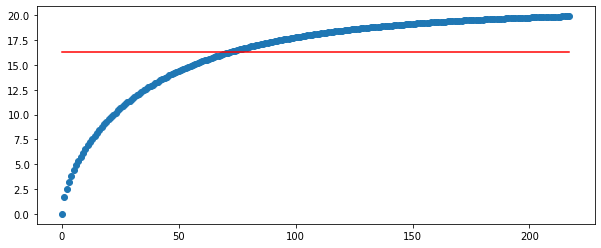

In [160]:
pred_val = fit.predict(pred_matrix[:,20:21])
plt.figure(figsize=(10,4))
plt.scatter(x=list(range(len(capacity))),y=capacity)
plt.plot(pred_val,'r')
# plt.ylim(,20)
plt.show()

In [161]:
rmse(x=capacity,y=pred_val)

4.229407509971316

In [162]:
r2(capacity,pred_val.reshape(-1,))

-4.440892098500626e-16

# Adaptive Lasso

In [163]:
enet = ElasticNetCV(l1_ratio=0,alphas=np.arange(0,1,0.2))
fit = enet.fit(pred_matrix,capacity)
temp_coefs = fit.coef_
enet = ElasticNetCV(l1_ratio=1/abs(min(temp_coefs)))
fit = enet.fit(pred_matrix,capacity)

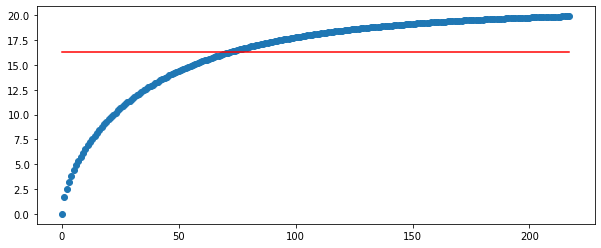

In [164]:
pred_val = fit.predict(pred_matrix)
plt.figure(figsize=(10,4))
plt.scatter(x=list(range(len(capacity))),y=capacity)
plt.plot(pred_val,'r')
# plt.ylim(,20)
plt.show()

In [165]:
fit = lm.fit(X=pred_matrix[:,1:2],y=np.array(capacity).reshape(-1,1))
fit.coef_

array([[8.66925391]])

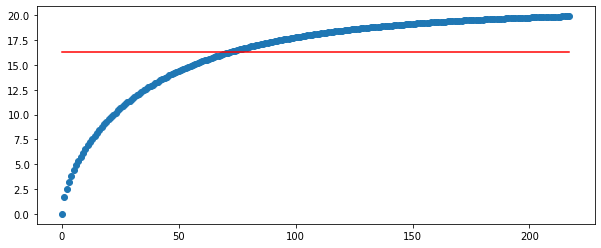

In [166]:
pred_val = fit.predict(pred_matrix[:,1:2])
plt.figure(figsize=(10,4))
plt.scatter(x=list(range(len(capacity))),y=capacity)
plt.plot(pred_val,'r')
# plt.ylim(,20)
plt.show()

In [167]:
rmse(x=capacity,y=pred_val)

4.229407509971316

In [168]:
r2(capacity,pred_val.reshape(-1,))

-4.440892098500626e-16

# LASSO

In [169]:
enet = ElasticNetCV(l1_ratio=1)
fit = enet.fit(pred_matrix,capacity)
temp_lambda = fit.alphas_
new_lambda = [math.exp(i) for i in np.linspace(np.log(temp_lambda[1]),np.log(temp_lambda[5]),100)]
enet = ElasticNetCV(l1_ratio=1,alphas=new_lambda)
fit = enet.fit(pred_matrix,capacity)

In [170]:
fit.coef_

array([ 0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., -0., -0.,  0.,  0., -0.,  0.,  0.,  0.,
        0.,  0., -0.,  0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., -0.,  0.,  0., -0., -0., -0.,  0., -0.,
       -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,
        0., -0.,  0.,  0., -0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0.,
       -0.,  0.,  0., -0.,  0., -0., -0.,  0., -0.,  0.,  0.,  0., -0.,
       -0.,  0.,  0., -0.,  0.,  0.,  0., -0., -0.])

In [171]:
fit = lm.fit(X=pred_matrix[:,18:19],y=np.array(capacity).reshape(-1,1))
fit.coef_

array([[-8.66925391]])

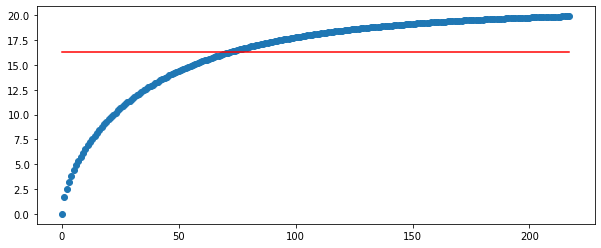

In [172]:
pred_val = fit.predict(pred_matrix[:,18:19])
plt.figure(figsize=(10,4))
plt.scatter(x=list(range(len(capacity))),y=capacity)
plt.plot(pred_val,'r')
# plt.ylim(,20)
plt.show()

In [173]:
rmse(x=capacity,y=pred_val)

4.229407509971316

In [174]:
r2(capacity,pred_val.reshape(-1,))

-4.440892098500626e-16

# SCAD

In [175]:
enet= ElasticNetCV(l1_ratio=3.7)
fit = enet.fit(pred_matrix,capacity)
fit.coef_

array([-0., -0., -0.,  0., -0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0.,
       -0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0.,  0., -0.,  0.,  0.,
       -0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0., -0.,
        0., -0.,  0., -0., -0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0.,
        0., -0.,  0., -0., -0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0., -0.,
        0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.])

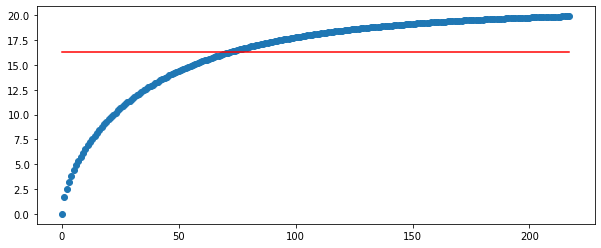

In [176]:
pred_val = fit.predict(pred_matrix)
plt.figure(figsize=(10,4))
plt.scatter(x=list(range(len(capacity))),y=capacity)
plt.plot(pred_val,'r')
# plt.ylim(,20)
plt.show()

In [177]:
rmse(x=capacity,y=pred_val)

4.229407509971315

In [178]:
r2(capacity,pred_val.reshape(-1,))

-2.220446049250313e-16

In [179]:
fit = lm.fit(X=pred_matrix[:,12:13],y=np.array(capacity).reshape(-1,1))
fit.coef_

array([[17.33850781]])

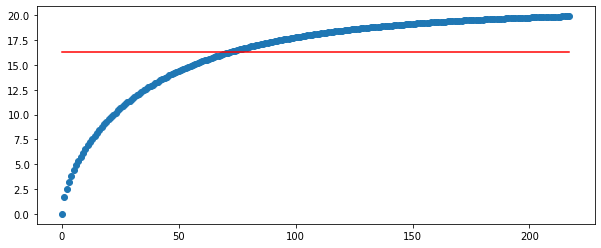

In [180]:
pred_val = fit.predict(pred_matrix[:,12:13])
plt.figure(figsize=(10,4))
plt.scatter(x=list(range(len(capacity))),y=capacity)
plt.plot(pred_val,'r')
plt.show()

In [181]:
rmse(x=capacity,y=pred_val)

4.229407509971316

In [182]:
r2(capacity,pred_val.reshape(-1,))

-4.440892098500626e-16

In [183]:
fit = lm.fit(X=pred_matrix[:,30:31],y=np.array(capacity).reshape(-1,1))
fit.coef_

array([[-17.33850781]])

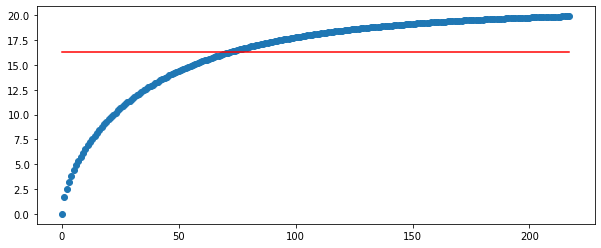

In [184]:
pred_val = fit.predict(pred_matrix[:,30:31])
plt.figure(figsize=(10,4))
plt.scatter(x=list(range(len(capacity))),y=capacity)
plt.plot(pred_val,'r')
plt.show()

In [185]:
rmse(x=capacity,y=pred_val)

4.229407509971315

In [186]:
r2(capacity,pred_val.reshape(-1,))

-2.220446049250313e-16

# Fused Lasso

In [187]:
# library(genlasso)
# fit = fusedlasso2d(capacity, pred_matrix, 10, 10)
# plot(fit$beta[, 50])
# which(fit$beta[,50] > .02)

In [188]:
pred_matrix = pd.DataFrame(pred_matrix)
pred_matrix.columns = ['a'+str(i) for i in pred_matrix.columns]
pred_matrix['capacity'] = capacity

In [189]:
pred_matrix

,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,...,a91,a92,a93,a94,a95,a96,a97,a98,a99,capacity
0,0.751268,0.742431,0.733714,0.725114,0.71663,0.70826,0.700003,0.691856,0.683818,0.675887,...,0.27576,0.272936,0.270145,0.267385,0.264658,0.261961,0.259296,0.256661,0.254056,0.000000
1,0.751268,0.742431,0.733714,0.725114,0.71663,0.70826,0.700003,0.691856,0.683818,0.675887,...,0.27576,0.272936,0.270145,0.267385,0.264658,0.261961,0.259296,0.256661,0.254056,1.651814
2,0.751268,0.742431,0.733714,0.725114,0.71663,0.70826,0.700003,0.691856,0.683818,0.675887,...,0.27576,0.272936,0.270145,0.267385,0.264658,0.261961,0.259296,0.256661,0.254056,2.536165
3,0.751268,0.742431,0.733714,0.725114,0.71663,0.70826,0.700003,0.691856,0.683818,0.675887,...,0.27576,0.272936,0.270145,0.267385,0.264658,0.261961,0.259296,0.256661,0.254056,3.240852
4,0.751268,0.742431,0.733714,0.725114,0.71663,0.70826,0.700003,0.691856,0.683818,0.675887,...,0.27576,0.272936,0.270145,0.267385,0.264658,0.261961,0.259296,0.256661,0.254056,3.847861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,0.751268,0.742431,0.733714,0.725114,0.71663,0.70826,0.700003,0.691856,0.683818,0.675887,...,0.27576,0.272936,0.270145,0.267385,0.264658,0.261961,0.259296,0.256661,0.254056,19.857600
214,0.751268,0.742431,0.733714,0.725114,0.71663,0.70826,0.700003,0.691856,0.683818,0.675887,...,0.27576,0.272936,0.270145,0.267385,0.264658,0.261961,0.259296,0.256661,0.254056,19.864824
215,0.751268,0.742431,0.733714,0.725114,0.71663,0.70826,0.700003,0.691856,0.683818,0.675887,...,0.27576,0.272936,0.270145,0.267385,0.264658,0.261961,0.259296,0.256661,0.254056,19.871954
216,0.751268,0.742431,0.733714,0.725114,0.71663,0.70826,0.700003,0.691856,0.683818,0.675887,...,0.27576,0.272936,0.270145,0.267385,0.264658,0.261961,0.259296,0.256661,0.254056,19.878989


In [190]:
model = smf.ols(formula='capacity~a22+a2+a98',data=pred_matrix).fit()

In [191]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               capacity   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                -2.519e-14
Date:                Fri, 14 May 2021   Prob (F-statistic):               1.00
Time:                        14:52:23   Log-Likelihood:                -623.70
No. Observations:                 218   AIC:                             1251.
Df Residuals:                     216   BIC:                             1258.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.3949      0.148     56.673      0.0

In [198]:
fit = lm.fit(pred_matrix[['a2','a22','a98']],np.array(capacity).reshape(-1,1))

In [199]:
fit.coef_

array([[-7.12663412e+30, -3.56331706e+30, -3.56331706e+30]])

In [201]:
rmse(capacity, pred_val)

4.229407509971315

In [205]:
pred_matrix['capacity'].shape

(218,)

In [203]:
r2(pred_matrix['capacity'], pred_val)

Exception: Data must be 1-dimensional

# SRE Solve

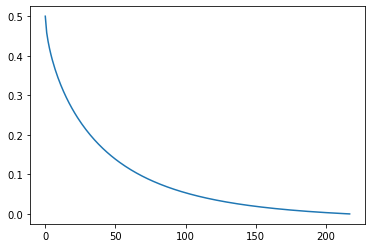

In [43]:
# normalized capacity

norm_capacity = capacity
m = max(norm_capacity)
norm_capacity =( norm_capacity - m )/ (- 2 * m)
plt.plot(norm_capacity)
plt.show()

In [44]:
b_range = np.linspace(0.4,0.7,100)
b_matrix = np.zeros([len(response['cycles']),len(b_range)])
for i in range(len(b_range)):
    b_matrix[:,i] = response['cycles']*b_range[i]

In [45]:
enet = ElasticNetCV(l1_ratio=0.5)
fit = enet.fit(b_matrix,norm_capacity)

fit.intercept_

0.24799004306357647

In [46]:
fit.coef_

array([-3.91313335e-04, -2.33409369e-05, -2.02104492e-05, -1.97592565e-05,
       -1.93255059e-05, -1.89043628e-05, -1.84953683e-05, -1.80980876e-05,
       -1.77121042e-05, -1.73370195e-05, -1.69724515e-05, -1.66180340e-05,
       -1.62734164e-05, -1.59382622e-05, -1.56122487e-05, -1.52950665e-05,
       -1.49864185e-05, -1.46860196e-05, -1.43935961e-05, -1.41088850e-05,
       -1.38316337e-05, -1.35615995e-05, -1.32985490e-05, -1.30422580e-05,
       -1.27925107e-05, -1.25490996e-05, -1.23118250e-05, -1.20804947e-05,
       -1.18549238e-05, -1.16349341e-05, -1.14203541e-05, -1.12110184e-05,
       -1.10067679e-05, -1.08074490e-05, -1.06129139e-05, -1.04230198e-05,
       -1.02376292e-05, -1.00566093e-05, -9.87983218e-06, -9.70717414e-06,
       -9.53851594e-06, -9.37374243e-06, -9.21274239e-06, -9.05540842e-06,
       -8.90163676e-06, -8.75132716e-06, -8.60438273e-06, -8.46070982e-06,
       -8.32021788e-06, -8.18281937e-06, -8.04842961e-06, -7.91696670e-06,
       -7.78835137e-06, -

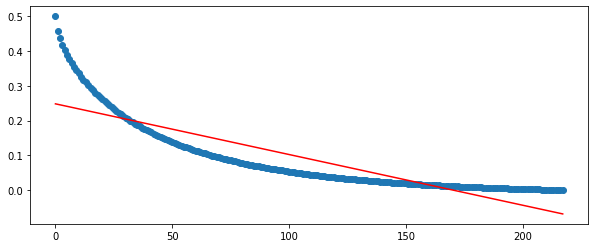

In [47]:
X = b_matrix[:,95]-1
X = pd.DataFrame(X,columns=['b_matrix'])
X['norm_capacity'] = norm_capacity
fit = smf.glm(formula='norm_capacity~b_matrix',data=X).fit()
pred_val = fit.predict(X['b_matrix'])
plt.figure(figsize=(10,4))
plt.scatter(x=list(range(len(norm_capacity))),y=norm_capacity)
plt.plot(pred_val,'r')
plt.show()